# Mnist 실습

필기체 이미지를 분류하는 간단한 인공지능을 만들어보자. 

![img](https://t1.daumcdn.net/cfile/tistory/22606B435974B30434)


### 숫자 손글씨 인식기 만들기 (Sequential Model을 이용하는 방법)

숫자 손글씨 분류기는 손으로 쓴 숫자 이미지를 입력받으면, 그 이미지가 어떤 숫자를 나타내는지 출력해낼 수 있다. 


> 어떻게 만들어?

일반적으로 딥러닝 기술은 **데이터 준비 -> 딥러닝 네트워크 설계 -> 학습 -> 테스트(평가)**의 순서로 만들게 된다.

## 1. 데이터 준비


### Mnist 숫자 손글씨 Dataset 불러들이기

텐서플로우(Tensorflow)의 표준 API인 `tf.keras`의 **Sequential API**를 이용하여 숫자 손글씨 인식기를 만들어보자. 

구글에서 오픈소스로 제공하는 텐서플로우는 가장 널리 사용되고 있는 머신러닝 라이브러리 중 하나다. 딥러닝 구현 실습은 Tensorflow 버전 2.0 (혹은 그 이상)에서 진행될 예정이다. 


먼저 아래 코드를 실행해보자. 

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

#mnist 로드. 케라스에 내장되어있는 데이터셋
mnist = keras.datasets.mnist

#사전에 다운로드 되어있지 않았다면 다운로드까지 진행
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(len(x_train))

2.2.0
60000


위의 코드를 보면 숫자 손글씨 데이터인 MNIST 데이터셋을 쉽게 읽어들일 수 있다. 
또한 학습 데이터는 60,000개가 있는 것을 확인할 수 있다. 

불러들인 숫자 손글씨 이미지 하나를 출력해보자. MNIST 데이터셋의 X항목은 이미지 데이터를 담는 행렬이고 y항목은 이 이미지에 대한 결과값, 즉 숫자이다.

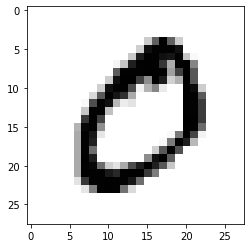

In [3]:
plt.imshow(x_train[1],cmap=plt.cm.binary)
plt.show()

숫자 0의 이미지가 나왔다. 이는 x_train\[1\]에 담긴 이미지의 의미는 0이라는 것이다.

마찬가지로 y항목의 내요도 출력해보자.

In [4]:
print(y_train[1])

0


y항목에는 x항목에 들어있는 이미지에 대응하는 실제 숫자값이 담겨있다.

### 학습용 데이터와 시험용 데이터

```python
(x_train, y_train), (x_test, y_test) = mnist.load_data()
```

`mnist.load()` 함수를 통해 학습용 데이터 `(x_train, y_train)`와 시험용 데이터 `(x_test, y_test)`를 나누어서 받아들이는 것을 볼 수 있다. 


In [7]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


학습 데이터는 60000개, 시험 데이터는 10000개가 저장되어있음을 알 수 있다. 저 시험용 데이터는 머신러닝의 학습이 overfitting 되는 것을 방지하기 위해 필요하다.

![img](https://t1.daumcdn.net/cfile/tistory/9951E5445AAE1BE025)

위와 같이 전체 데이터가 있으면 training, test, validation set으로 나눈 것을 볼 수 있다. 모델의 정확도를 미리 예측하고, overfitting을 막고, 여러 머신러닝 모델 중 가장 정확성이 좋은 모델을 선택하기위 validation set을 이용한다.

자세한 내용은 아래 링크 참고!

[Machine Learning에서 validation set을 사용하는 이유](https://3months.tistory.com/118)

### 데이터 전처리 하기

숫자 솔글씨 이미지의 실제 픽셀 값은 0부터 255 사이의 값을 가진다. 

In [8]:
print('최소값 : ', np.min(x_train), '최대값 : ', np.max(x_train))

최소값 :  0 최대값 :  255


인공지능 모델을 훈련시키고 사용할 때, 일반적으로 입력은 0\~1 사이의 값으로 정규화 시켜주는 것이 좋다. MINIST 데이터는 각 픽셀 값이 0~255 사이 범위에 있으므로 데이터들을 255.0으로 나누어 준다.

최소값이 0, 최대값이 1에 근접하도록 나오는지 확인해보자.

In [10]:
x_train_norm, x_test_norm = x_train/255.0, x_test/255.0

print('최소값 : ', np.min(x_train_norm), '최대값 : ', np.max(x_test_norm))

최소값 :  0.0 최대값 :  1.0


## 2. 딥러닝 네트워크 설계하기

### Sequential Model을 사용해보자

데이터가 모두 준비되었다. 이제 딥러닝 네트워크를 만들어 볼 시간이다.

이번에는 텐서플로우 케라스(tf.keras)에서 Sequential API라는 방법을 사용할 것이다. Sequential API는 개발의 자유도는 많이 떨어지지만, 매우 간단하게 딥러닝 모델을 설계할 수 있다. 손쉽게 딥러닝 레이어를 추가할 수 있으며, 케라스에서 모델을 만드는 방법은 Sequential API외에도 Functional API를 이용하는 방법, 밑바닥부터 직접 코딩하는 방법 등이 있다.

아래 코드는 tf.keras에서 Sequential API를 이용하여 **LeNet**이라는 딥러닝 네트워크를 설계한 예시이다. 간단한 코드지만 손글씨 숫자 분류기를 구현하는 데에는 충분하다.

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(32,(3, 3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

print("Model에 추가된 Layer 개수 : ", len(model.layers))

Model에 추가된 Layer 개수 :  7


![img](https://aiffelstaticprd.blob.core.windows.net/media/images/F-1-5.max-800x600.png)

- Conv2D 레이어의 첫 번째 인자는 사용하는 이미지 특징의 수다. 여기서는 16과 32를 사용했다. 가장 먼저 16개의 이미지 특징을, 그 뒤에 32개의 이미지 특징씩을 고려하겠다는 의미다. 복잡한 이미지라면 (예. 사람 얼굴) 이 특징 숫자를 늘려주는 것을 고려할 수 있다.
- Dense 레이어의 첫번째 인자는 분류기에 사용되는 뉴런의 숫자다. 이 값이 클수록 보다 복잡한 분류기를 만들 수 있다. 10개의 숫자가 아닌 알파벳을 구분하고 싶다면, 대문자 26개, 소문자 26개로 총 52개의 클래스를 분류해야한다. 그래서 32보다 큰 64, 128 등을 고려해볼 수 있다.
- 마지막 Dense 레이어의 뉴런 숫자는 결과적으로 분류해야하는 클래스 수로 지정하면 된다. 숫자 인식기에서는 10, 알파벳 인식기에서는 52가 된다.


만든 딥러닝 네트워크 모델을 확인해보려면 `model.summary()` 메소드를 이용하면 된다.

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

## 3. 딥러닝 네트워크 학습시키기

우리가 만든 네트워크의 입력은 `(데이터 갯수, 이미지 크기x, 이미지 크기y, 채널수)`와 같은 형태를 가진다. 이전 스텝에서 첫번째 레이어에 `input_shape=(28, 28, 1)`로 지정했었다.

그런데 `print(x_train.shape)`를 해보면, `(60000, 28, 28)`로 채널수에 대한 정보가 없다. 따라서 `(60000, 28, 28, 1)`로 만들어주어야 한다. (여기서 채널수 1은 흑백 이미지를 의미한다. 컬러 이미지라면 R, G, B 세가지 값이기 때문에 3이다.)

In [15]:
print("Before Reshape - x_train_norm shape : {}".format(x_train_norm.shape))
print("Before Reshape - x_test_norm shape : {}".format(x_test_norm.shape))

x_train_reshaped = x_train_norm.reshape(-1, 28, 28, 1) # 데이터 갯수에 -1을 쓰면 reshape시 자동으로 계산된다.
x_test_reshaped = x_test_norm.reshape(-1, 28, 28, 1)

print("After Reshape - x_train_norm shape : {}".format(x_train_norm.shape))
print("After Reshape - x_test_norm shape : {}".format(x_test_norm.shape))

Before Reshape - x_train_norm shape : (60000, 28, 28)
Before Reshape - x_test_norm shape : (10000, 28, 28)
After Reshape - x_train_norm shape : (60000, 28, 28)
After Reshape - x_test_norm shape : (10000, 28, 28)


이제 `x_train` 학습데이터로 딥러닝 네트워크를 학습시켜보자. 여기서 epochs = 10은 전체 60,000개의 데이터를 10번 반복해서 학습시키라는 의미다. 물론 model의 입력 정의에 형태를 맞춘 `x_train_reshaped`가 사용되어야 한다.

In [16]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_reshaped, y_train, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1953 - accuracy: 0.9420
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0638 - accuracy: 0.9801
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0454 - accuracy: 0.9860
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0350 - accuracy: 0.9892
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0291 - accuracy: 0.9909
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0235 - accuracy: 0.9925
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0188 - accuracy: 0.9942
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0158 - accuracy: 0.9948
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0129 - accuracy: 0.9955
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.011

## 4. 얼마나 잘 만들었는지 확인하기

### 테스트 데이터로 성능을 확인해보기

위에 테스트는 validation set, 즉 training set의 일부를 사용한 것이다. 과연 이 모델이 test data에서도 잘 작용할까?

시험용 데이터 `x_text`를 가지고 확인해보자.

In [17]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)

print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

313/313 - 2s - loss: 0.0364 - accuracy: 0.9901
test_loss : 0.036440543830394745
test_accuracy : 0.9901000261306763


결과가 나쁘지 않긴 하지만, 트레이닝셋보다 정확도가 떨어졌다.

### 어떤 데이터를 잘못 추론했을까? 확인해보자.

`model.evaluate()` 대신 `model.predict()`를 사용하면 model이 입력값을 보고 실제로 추론한 확률분포를 출력할 수 있다. 우리가 만든 model이란 사실 10개의 숫자 중 어느 것일지에 대한 확률값을 출력하는 함수다.

이 함수의 출력값, 즉 확률값이 가장 높은 숫자가 바로 model이 추론한 숫자가 된다.

In [19]:
predicted_result = model.predict(x_test_reshaped) # 모델이 추론한 확률값.
predicted_labels = np.argmax(predicted_result, axis=1)

idx = 0 
print("model.predict() 결과 : ", predicted_result[idx])
print("model이 추론한 가장 가능성 높은 결과 : ", predicted_labels[idx])
print("실제 데이터의 라벨 : ", y_test[idx])

model.predict() 결과 :  [9.4768566e-08 3.2840468e-08 8.8844399e-06 1.0615840e-04 3.9865014e-09
 1.3751206e-08 1.4640910e-11 9.9988484e-01 1.8163474e-08 3.6948819e-08]
model이 추론한 가장 가능성 높은 결과 :  7
실제 데이터의 라벨 :  7


`model.predict()`의 결과가 `[9.4768566e-08 3.2840468e-08 8.8844399e-06 1.0615840e-04 3.9865014e-09
 1.3751206e-08 1.4640910e-11 9.9988484e-01 1.8163474e-08 3.6948819e-08]`의 벡터 형태로 나왔다.
 
이 벡터는 model이 추론한 결과가 각각 0, 1, 2, ..., 7, 8, 9일 확률을 의미한다.

이 경우라면 model이 추론한 결과가 7일 확률이 1.00에 근접하고 있다. 즉, 이 모델은 입력한 이미지가 7이라는 것을 아주 확신하고 있다는 뜻이다. 


한번 실제 결과를 확인해보자.

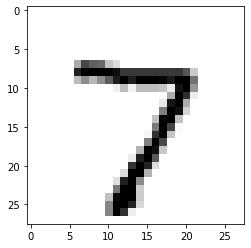

In [20]:
plt.imshow(x_test[idx], cmap = plt.cm.binary)
plt.show()

그렇다면 model이 추론해낸 숫자와 실제 라벨의 값이 다른 경우는 어떤 경우인지 직접 확인해보자.

예측 확률 분포 : [8.83760687e-04 1.11265235e-05 1.65880099e-01 4.51249944e-04
 6.36902332e-05 2.90642941e-08 1.03537057e-09 8.26271832e-01
 3.27667152e-03 3.16152186e-03]
라벨 : 2, 예측 결과 : 7


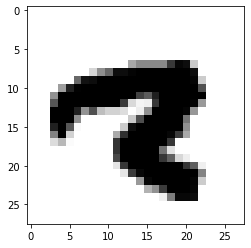

예측 확률 분포 : [7.03128219e-01 2.93763325e-09 3.14743374e-07 1.13530834e-11
 2.83216536e-01 2.72238954e-10 4.87409020e-03 1.20456214e-11
 8.77845939e-03 2.34742242e-06]
라벨 : 6, 예측 결과 : 0


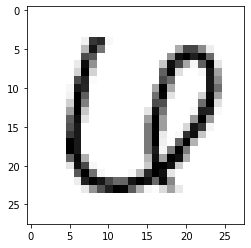

예측 확률 분포 : [4.2650225e-10 1.2862118e-07 1.8747243e-04 6.8296760e-01 1.4418050e-06
 7.6177479e-08 2.1168676e-14 3.1569037e-01 2.3590787e-06 1.1504450e-03]
라벨 : 7, 예측 결과 : 3


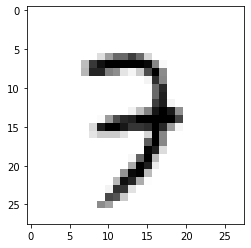

예측 확률 분포 : [1.7958440e-05 9.4247069e-03 6.4025629e-01 1.8759163e-01 6.5132529e-02
 4.7332922e-04 2.7320969e-08 1.3495676e-02 8.1807248e-02 1.8006187e-03]
라벨 : 8, 예측 결과 : 2


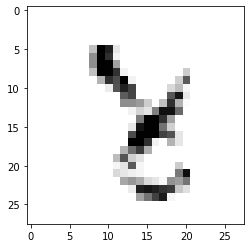

예측 확률 분포 : [4.6711805e-12 6.5516508e-07 8.8846041e-03 9.9106795e-01 7.8731830e-09
 2.0272342e-08 2.5185108e-15 1.9330055e-05 2.7349688e-05 1.9582142e-08]
라벨 : 2, 예측 결과 : 3


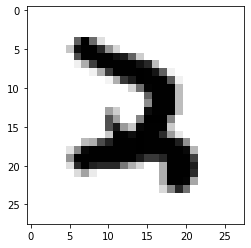

In [22]:
import random

wrong_predict_list = []

for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아보자.
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)
        
# wrong_predict_list에서 랜덤하게 5개만 뽑아보자.
samples = random.choices(population = wrong_predict_list, k=5)

for n in samples:
    print("예측 확률 분포 : " + str(predicted_result[n]))
    print("라벨 : " + str(y_test[n]) + ", 예측 결과 : " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap = plt.cm.binary)
    plt.show()

## 더 좋은 네트워크 만들어보기

더 높은 정확도를 이끌어내기 위해서 무엇을 할 수 있을까?

네트워크의 구조 자체는 바꾸지 않으면서도 해볼 수 있는 것들이 있다. 하이퍼파라미터들을 바꾸어보는 것인데, `Conv2D` 레이어에서 입력 이미지의 특징 수를 늘리거나 줄여보거나, `Dense` 레이어에서 뉴런 수를 바꾸어보거나, 학습 반복 횟수인 `epoch` 값을 변경해볼 수 있다.

In [ ]:
# 바꿔볼 수 있는 하이퍼파라미터들
n_channel_1 = 16
n_channel_2 = 32
n_dense = 48
n_train_epoch = 10

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3, 3), activation = 'relu', input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Con2D(n_channel_2, (3, 3), activation = 'relu'))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.summary()
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs = n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss : {}".format(test_loss))
p